In [1]:
import h5py # needs conda/pip install h5py
import os
os.chdir(r'C:\Users\jared\OneDrive\Documents\School\Thesis')

import sys
sys.path.append(r'C:\users\jared\anaconda3\lib\site-packages')
# import command_file

import matplotlib.pyplot as plt
import pandas as pd
import spear as sp
import numpy as np
from pathlib import Path  
import time
import math
import os
from sklearn.model_selection import train_test_split
from scipy import ndimage

# import gruHelperScript as ghs
# import lstmHelperScript as lhs
# import encoderDecoderHelperScript as edhs

DATA_PATH    = 'D:\SEVIR Data\data'
CATALOG_PATH = 'D:\SEVIR Data/CATALOG.csv'

# Read catalog
catalog = pd.read_csv(CATALOG_PATH,parse_dates=['time_utc'],low_memory=False)

# Desired image types
img_types = set(['vil'])

# Group by event id, and filter to only events that have all desired img_types
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')
event_ids = list(events.groups.keys())
print('Found %d events matching' % len(event_ids),img_types)

Found 20273 events matching {'vil'}


# CHANGE FOR LOOP BELOW TO DO ALL FILES

In [2]:
import master_script_helper_functions as mshf

Found 20273 events matching {'vil'}


In [3]:
# maskingThreshold = [150, 75, 94, 113, 144, 81, 69, 138, 100, 50, 125, 106, 88, 56, 119, 131, 63]
# numSTD = [1.8, 2.1, 1.5, 3, 1.3, 2.6, 1.6, 2.9, 2, 2.3, 1.9, 2.5, 1, 2.8, 1.4, 2.4, 1.1]

# maskingThreshold = [46, 17, 24, 32, 96, 125, 82, 75, 68, 89, 118, 111, 103, 39, 10, 53, 60]
# numSTD = [1.5, 0.5, 0.7, 1, 1.4, 0.5, 0.4,1.3, 0.8, 0.1, 1.2, 0.9, 0.6, 0.2, 1.1, 1.2, 0.3]

# maskingThreshold = [58, 36, 41, 47, 98, 120, 86, 81, 75, 92, 114, 109, 103, 53, 30, 64, 69]
# numSTD = [1.5, 0.8, 0.9, 1.1, 1.4, 0.8, 0.7, 1.4, 1, 0.5, 1.3, 1.1, 0.9, 0.6, 1.2, 1.3, 0.6]

maskingThreshold = [50]
numSTD = [1]
# input_lengths = [8]
# horizon_lengths = [1]

# numSTD = [1, 1, 1, 1]
# maskingThreshold = [114, 65, 50, 50]
globalMeans = []
globalSTDs = []

# for i in range(len(numSTD)):
#     np_data, np_data_no_text = mshf.createParameters(maskingThreshold[i], numSTD[i])
# [Binarization Threshold, numSTD] are the inputs above

# maskingThreshold = [150, 75, 94, 113, 144, 81, 69, 138, 100, 50, 125, 106, 88, 56, 119, 131, 63]
# numSTD = [1.8, 2.1, 1.5, 3, 1.3, 2.6, 1.6, 2.9, 2, 2.3, 1.9, 2.5, 1, 2.8, 1.4, 2.4, 1.1]

# Creating X and Y For and Pytorch Data Loaders for Models

In [4]:
def createXY(dataset, input_length, horizon_length):
    X = []
    Y = []
    for sample in dataset:
        for i in range(len(sample) - input_length - horizon_length + 1):
            x = torch.tensor(sample[i:i+input_length], dtype=torch.float32)
            y = torch.tensor(sample[i+input_length:i+input_length+horizon_length], dtype=torch.float32)
#             x_padded = pad_sequence(x, max_input_len, 0)
#             y_padded = pad_sequence(y, max_horizon_len, 0)
            X.append(x)
            Y.append(y)
    return X, Y

In [5]:
def normalizeDataset(train, test):
    stacked_train = np.array(np.vstack(train))
    stacked_train = stacked_train.astype(np.float64)
    means = np.mean(stacked_train, axis=0)
    stds =  np.std(stacked_train, axis=0)
    global globalMeans
    global globalSTDs
    globalMeans = means
    globalSTDs = stds
    normalized_train = (stacked_train - means) / stds
    train_return = normalized_train.reshape(-1,48,13)
    
    stacked_test = np.array(np.vstack(test))
#     stacked_test = stacked_test.astype(np.float64)
    normalized_test = (stacked_test - means) / stds
    test_return = normalized_test.reshape(-1,48,13)
    return train_return, test_return

In [6]:
def removeZeroEvents(dataset):
    print(dataset.shape)
    
    dataset = dataset.astype(np.float64)
    valid_events_mask = ~np.any(np.isnan(dataset), axis=(1, 2))
    # Use the mask to filter out the invalid events
    filtered_data = dataset[valid_events_mask]
    
    new_set = []
    for event in filtered_data:
        if not(np.any(event[:, 0:2] < 3)):
            new_set.append(event)
    new_set = np.array(new_set)
    new_set = new_set.astype(np.float64)
#     valid_events_mask = ~np.any(np.isnan(new_set), axis=(1, 2))
#     # Use the mask to filter out the invalid events
#     filtered_data = new_set[valid_events_mask]
    
    print(new_set.shape)
    return new_set


In [7]:
def createInputOutputs(dataset, input_length, output_lengths, rand_state, test_percent=0.2):
    """    
    Inputs: Dataset, input_lengths, output_lengths (horizons), test_set_percentage (20% default)
    
    Removes zero events
    Splits into train/test (80/20 ratio default)
    Normalizes train, then normalizes test using train means
    Creates dictionary of X/Y vectors for each input/output combo
    Returns dictionary of X/Y vectors for both train and test set
    
    Returns: normalized dictionary of X/Y Vectors for every input/output combo
    """
    dataset = removeZeroEvents(dataset)
#     Split intro train/test with default 20% test and then normalize
    train, test = train_test_split(dataset, test_size=test_percent, random_state=rand_state)
    norm_train, norm_test = normalizeDataset(train, test)
    
    train_dict = {}
    test_dict = {}
    min_set_size = 20000
#     Create dictionary with keys of (input_length, horizon_length)
#     Each keys has a value with the X vectors as ["X"] and y vectors as ["y"]
#     for input_length in input_lengths:
    for horizon_length in horizon_lengths:
        print("Creating input and output vectors for Input: " + str(input_length) + " Horizon: " + str(horizon_length))
        train_x, train_y = createXY(norm_train, input_length, horizon_length)
        key = (input_length, horizon_length)  # Create a key for the combination
        train_dict[key] = {"X": [], "Y": []}
        train_dict[key]["X"].append(train_x)
        train_dict[key]["Y"].append(train_y)

        test_x, test_y = createXY(norm_test, input_length, horizon_length)
#         key = (input_length, horizon_length)  # Create a key for the combination
        test_dict[key] = {"X": [], "Y": []}
        test_dict[key]["X"].append(test_x)
        test_dict[key]["Y"].append(test_y)
        if(len(train_x) < min_set_size):
            min_set_size = len(train_x)
    return train_dict, test_dict, min_set_size

In [8]:
from torch.utils.data import DataLoader, Dataset

class SeqDataset(Dataset):
    def __init__(self, X_data, Y_data, X_lengths, Y_lengths):
        self.X_data = X_data
        self.Y_data = Y_data
        self.X_lengths = X_lengths
        self.Y_lengths = Y_lengths

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X = self.X_data[idx]
        Y = self.Y_data[idx]
        X_len = self.X_lengths[idx]
        Y_len = self.Y_lengths[idx]
        
        return X, Y, X_len, Y_len

In [9]:
# Custom collate_fn to pad X and unpack Y sequences
def collate_fn(batch):
    # Sort by length in descending order (for packing)
    batch.sort(key=lambda x: x[2], reverse=True)
    
    X, Y, X_lengths, Y_lengths = zip(*batch)
    
    # Pad X sequences
    X_padded = pad_sequence(X, batch_first=True, padding_value=0)
    
    # Stack Y sequences (no padding here, since Y is unpadded)
    Y_padded = pad_sequence(Y, batch_first=True, padding_value=0)
    
    # Convert lists to tensors
    X_lengths = torch.tensor(X_lengths)
    Y_lengths = torch.tensor(Y_lengths)

    return X_padded, Y_padded, X_lengths, Y_lengths

In [10]:
def trimSets(dictionary, max_size, input_length):
#     Equalize size of each input/horizon pairing in train dictionary (max set size is 1.5x smallest set size)
    for horizon_length in horizon_lengths:
        X = dictionary[(input_length, horizon_length)]["X"][0]
        y = dictionary[(input_length, horizon_length)]["Y"][0]

        if(len(X) > max_size):
            random_indices = random.sample(range(len(X)), max_size)
            # Slice the lists using the random indices
            X_Sampled = [X[i] for i in random_indices]
            y_Sampled = [y[i] for i in random_indices]

            dictionary[(input_length, horizon_length)]["X"][0] = X_Sampled
            dictionary[(input_length, horizon_length)]["Y"][0] = y_Sampled
    return dictionary

In [11]:
# Create merged X Y for train dataset
def mergeAllSets(dictionary, input_len):
    X_all_Train = []
    Y_all_Train = []
    # total = 0
    train_x_lengths = []
    train_y_lengths = []

    for horizon_length in horizon_lengths:
        # Get the data for the current (input_len, output_horizon) pair
        key = (input_len, horizon_length)
        X = dictionary[key]["X"][0]
        Y = dictionary[key]["Y"][0]
        X_all_Train = X_all_Train + X
        Y_all_Train = Y_all_Train + Y
        train_x_lengths = train_x_lengths + [input_len]*len(dictionary[key]["X"][0])
        train_y_lengths = train_y_lengths + [horizon_length]*len(dictionary[key]["Y"][0])
        
    return X_all_Train, Y_all_Train, train_x_lengths, train_y_lengths

In [12]:
def createDataLoader(X_all_Train, Y_all_Train, train_x_lengths, train_y_lengths):
    training_torch_dataset = SeqDataset(X_all_Train, Y_all_Train, train_x_lengths, train_y_lengths)

#     For testing purposes, take 20% of dataset
    dataset_size = len(training_torch_dataset) 
    subset_size = int(0.2 * dataset_size)  # Taking 20% of the dataset
    subset, _ = random_split(training_torch_dataset, [subset_size, dataset_size - subset_size])
    
    train_data_loader = DataLoader(training_torch_dataset, batch_size=256, shuffle=True, drop_last=True, 
                                   collate_fn=lambda batch: collate_fn(batch))
    return train_data_loader


In [13]:
def trainModel():
    criterion = nn.MSELoss()  # Assuming you are doing regression
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training model

        running_loss = 0.0
        for i, (X_batch, Y_batch, X_lengths, Y_lengths) in enumerate(train_data_loader):  # Assuming a data loader is used

            # Calculate percentage
            percent_done = (i + 1) / len(train_data_loader) * 100
            # Print progress
            print(f"Processing: {percent_done:.2f}% complete for epoch {epoch+1}", end='\r')


            # Move the batch to the same device as the model
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            X_lengths = X_lengths.to(device)
            Y_lengths = Y_lengths.to(device)

            # Forward pass
            Y_pred = model(X_batch, X_lengths, Y_lengths.max())

            # Compute loss on non-padded parts
            trimmed_y_pred = [arr[n-1] for arr, n in zip(Y_pred, Y_lengths)]
            trimmed_y_true = [arr[n-1] for arr, n in zip(Y_batch, Y_lengths)]
            trimmed_y_pred_tensor = torch.stack(trimmed_y_pred)
            trimmed_y_true_tensor = torch.stack(trimmed_y_true)

        #         print(trimmed_y_pred[0])
        #         print(trimmed_y_true[0])
            loss = criterion(trimmed_y_pred_tensor, trimmed_y_true_tensor)
#             loss = criterion(trimmed_y_pred_tensor[:,:-5], trimmed_y_true_tensor[:,:-5])
            train_loss.append(loss)
            # Zero the gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Print loss
        print(f"\nEpoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AutoregressiveLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(AutoregressiveLSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer for processing inputs
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layer to project hidden states to output
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Attention Layer
        self.attn = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, lengths, output_length):
        # Pack the padded sequence (for training only)
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Pass the packed input through LSTM
        packed_output, (hidden, cell) = self.lstm(packed_input)
        
        # Unpack the output (for training only, not used in autoregressive generation)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        # Now use hidden state to start autoregressive generation
        next_input = output[:, -1, :].unsqueeze(1)  # Last hidden state as input
        # Initialize hidden and cell states
        next_input = self.fc(next_input.squeeze(1)).unsqueeze(1)  # Shape: [batch_size, 1, input_size]

        hidden = hidden  # [num_layers, batch_size, hidden_size]
        cell = cell  # [num_layers, batch_size, hidden_size]
        
        outputs = []
        past_predictions = []  # Store past predictions for attention
        
        for t in range(output_length):
            # LSTM generates a new output
#             print("LSTM INPUT SIZE: " + str(x.shape))
            output_lstm, (hidden, cell) = self.lstm(next_input, (hidden, cell))
#             print("OUTPUT_LSTM SIZE: " + str(output_lstm.shape))

            # Use attention on past predictions
            if past_predictions:
                past_preds = torch.stack(past_predictions, dim=1)  # [batch_size, t, output_size]
                attn_weights = F.softmax(self.attn(past_preds), dim=1)  # Attention weights for past preds
                weighted_past_preds = torch.sum(attn_weights * past_preds, dim=1)  # Weighted sum of past predictions
#                 print("WEIGHTED PAST PREDS: " + str(weighted_past_preds.shape))
                output_lstm = output_lstm + weighted_past_preds.squeeze(1)  # Combine with new LSTM output
#                 print("OUTPUT_LSTM SIZE w attn: " + str(output_lstm.shape))
                
            # Fully connected layer for final prediction
            output = self.fc(output_lstm.squeeze(1))  # [batch_size, output_size]
            outputs.append(output)
            
            # Save the current prediction for future attention
            past_predictions.append(output_lstm.unsqueeze(1))  # Add to past predictions list
            
            # Use output as next input for autoregressive generation
            next_input = output.unsqueeze(1)  # This will be the sequence input for next timestep
#             print("OUTPUT SIZE: " + str(output.shape))

        return torch.stack(outputs, dim=1)  # Stack to form a sequence of shape [batch_size, output_length, output_size]

In [15]:
def makeTestSetDataloader(key):
    current_x_test = test_dataset[key]["X"][0]
    current_y_test = test_dataset[key]["Y"][0]
    current_x_test_lengths = [key[0]] * len(current_x_test)
    current_y_test_lengths = [key[1]] * len(current_y_test)
    current_test_dataset = SeqDataset(current_x_test, current_y_test, current_x_test_lengths, current_y_test_lengths)
    test_data_loader = DataLoader(current_test_dataset, batch_size=128, shuffle=True, drop_last=True, collate_fn=lambda batch: collate_fn(batch))
    return test_data_loader

In [16]:
def r2ByColumn(y_true, y_pred):
    # Calculate the mean of y_true along each column
    y_mean = np.mean(y_true, axis=0)
    # Calculate SS_tot and SS_res for each column
    ss_tot = np.sum((y_true - y_mean) ** 2, axis=0)
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    # Calculate R^2 for each column
    r2 = 1 - (ss_res / ss_tot)
    rounded_r2 = [np.round(x, 4) for x in r2]
    return rounded_r2

In [17]:
def globalR2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true, axis=0)) ** 2)
    r2_global = 1 - (ss_res / ss_tot)
    return r2_global

In [18]:
def evaluateModel():
    r2_dict = {}
    for key in test_dataset:
        print("KEYS IN TEST DATASET")
        print(key)
        test_data_loader = makeTestSetDataloader(key)
        predictions = []
        y_true = []
        for i, (X_batch, Y_batch, X_lengths, Y_lengths) in enumerate(test_data_loader):
            with torch.no_grad():
                batch_predictions = model(X_batch.to(device), X_lengths.to(device), Y_lengths.max().to(device))

            numpy_batch_predictions = batch_predictions.cpu().numpy()
    #         print(numpy_batch_predictions[0,:,:])
            numpy_batch_predictions = numpy_batch_predictions[:, -1, :] # Take only the final frame for computing r^2

    #         print(numpy_batch_predictions.shape)
            predictions.append(numpy_batch_predictions)
            batch_y_true = Y_batch[:, -1, :] # Take only the final frame for computing r^2
            y_true.append(batch_y_true.cpu().numpy())

        predictions_array = np.array(predictions)
    #     print("INPUT LENGTH: " + str(int(X_lengths[0])))
    #     print("HORIZON LENGTH: " + str(int(Y_lengths[0])))
    #     print("Predictions Length: " + str(predictions_array.shape))

    #     predictions_array = predictions_array.reshape(-1, Y_lengths[0], output_size)
        predictions_array = predictions_array.reshape(-1, 1, output_size)
        predictions_array = np.squeeze(predictions_array)
    #     print("Number of Samples: " + str(predictions_array.shape[0]) + "\n")

        y_true = np.array(y_true)
    #     y_true = y_true.reshape(-1, Y_lengths[0], output_size)
        y_true = y_true.reshape(-1, 1, output_size)
        y_true = np.squeeze(y_true)
    #     print("y_true Length: " + str(y_true.shape))

        r2_column = r2ByColumn(y_true, predictions_array)
        r2_first8 = globalR2(y_true[:,:-5], predictions_array[:,:-5])
        r2_global = globalR2(y_true, predictions_array)

        r2_dict[key] = {"first8": r2_first8, "global": r2_global}
    return r2_dict

In [19]:
def saveR2Dict(mT, nstd, input_length, splitn):
    np_path = "C:\\Users\\jared\\OneDrive\\Documents\\School\\Thesis\\Final Results\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\input_" + str(input_length) + "\\train_test_split_" + str(splitn) + "_r2_dict.pkl"

    # Extract the directory from the path (so we can create it)
    directory = os.path.dirname(np_path)

    # Create the directory if it doesn't exist
    try:
        print("Creating Directory for R2")
        os.makedirs(directory, exist_ok=True)  # exist_ok=True to prevent error if directory already exists
    except Exception as e:
        print(f"An error occurred while creating the directory: {e}")

    # Save the dictionary to the file using pickle
    with open(np_path, 'wb') as f:
        pickle.dump(r2s, f)  # Save the dictionary (r2s) into the .pkl file

# DEFINING GLOBAL VARIABLES

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import random
from itertools import product
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pickle
import os

train_loss = []
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Model Params
input_size = 13  # Feature dimension for each time step in X
output_size = 13  # Feature dimension for each time step in Y (same as input size)
hidden_size = 32
num_layers = 2
num_epochs = 3

In [22]:
# maskingThreshold = [114,  65,   50,   50]
# numSTD =           [1,    1,    1,    1]
# input_lengths =    [8,    4,    9,    13]
# horizon_lengths =  [1,    6,    12,   24]

maskingThreshold = [50]
numSTD = [1]
input_lengths = [9]
horizon_lengths = [12]

# Data/Model Creation, Model Training, Model Evaluation Loop

In [23]:
for index in range(len(numSTD)):
#     for in_length in range(len(input_lengths)):

#         10 different train_test splits
    splits = 1
    for i in range(splits):
        input_length = input_lengths[index]
        mT = maskingThreshold[index]
        nstd = numSTD[index]
        np_path = "D:\\Final Dataset\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\np_array_no_text.npy"
        dataset = np.load(np_path)
        train_dictionary, test_dataset, min_set_size = createInputOutputs(dataset, input_length, horizon_lengths, i, 0.2)
        max_size = int(min_set_size * 1.5)
        trimmed_train_dictionary = trimSets(train_dictionary, max_size, input_length)
        merged_X, merged_y, x_lengths, y_lengths = mergeAllSets(trimmed_train_dictionary, input_length)
        train_data_loader = createDataLoader(merged_X, merged_y, x_lengths, y_lengths)

        model = AutoregressiveLSTMWithAttention(input_size, hidden_size, output_size, num_layers).to(device)
        trainModel()
        r2s = evaluateModel()
        saveR2Dict(mT, nstd, input_length, i)
        
np.load = np_load_old


(17236, 48, 13)
(16198, 48, 13)
Creating input and output vectors for Input: 9 Horizon: 12
Processing: 100.00% complete for epoch 1
Epoch 1/3, Loss: 0.6937
Processing: 100.00% complete for epoch 2
Epoch 2/3, Loss: 0.3922
Processing: 100.00% complete for epoch 3
Epoch 3/3, Loss: 0.4416
KEYS IN TEST DATASET
(9, 12)
Creating Directory for R2


# Data Aggregation

In [24]:
# print(r2s[13,12]["by_column"])
# print(r2s[13,12]["global"])

# input_lengths = [8, 2, 4, 5, 18, 24, 15, 14, 13, 17, 23, 21, 20, 7, 1, 10, 11]
# horizon_lengths = [1, 6, 12, 24]
# maskingThreshold = [150, 75, 94, 113, 144, 81, 69, 138, 100, 50, 125, 106, 88, 56, 119, 131, 63]
# numSTD = [1.8, 2.1, 1.5, 3, 1.3, 2.6, 1.6, 2.9, 2, 2.3, 1.9, 2.5, 1, 2.8, 1.4, 2.4, 1.1]

# maskingThreshold = [46, 17, 24, 32, 96, 125, 82, 75, 68, 89, 118, 111, 103, 39, 10, 53, 60]
# numSTD = [1.5, 0.5, 0.7, 1, 1.4, 0.5, 0.4,1.3, 0.8, 0.1, 1.2, 0.9, 0.6, 0.2, 1.1, 1.2, 0.3]
# input_lengths = [12, 13, 2, 5, 7, 6, 15, 12, 8, 4, 3, 14, 11, 9, 10, 1, 5]
# horizon_lengths = [1, 6, 12, 24]

# maskingThreshold = [58, 36, 41, 47, 98, 120, 86, 81, 75, 92, 114, 109, 103, 53, 30, 64, 69]
# numSTD = [1.5, 0.8, 0.9, 1.1, 1.4, 0.8, 0.7, 1.4, 1, 0.5, 1.3, 1.1, 0.9, 0.6, 1.2, 1.3, 0.6]
# input_lengths = [13, 14, 4, 7, 8, 8, 15, 12, 9, 5, 5, 14, 11, 10, 11, 3, 6]
# horizon_lengths = [1, 6, 12, 24]

# maskingThreshold = [114]
# numSTD = [1]
# input_lengths = [8]
# horizon_lengths = [1]

# maskingThreshold = [1]
# numSTD = [65]
# input_lengths = [1, 2, 4, 8, 16, 24]
# horizon_lengths = [6]


# index = 4
# mT = maskingThreshold[index]
# nstd = numSTD[index]
# input_length = input_lengths[index]
# splitn = 1

In [25]:
for index in range(len(numSTD)):
    results_dict = {}
    
    first8_horz1 = 0
    first8_horz6 = 0
    first8_horz12 = 0
    first8_horz24 = 0
    
    total_horz1 = 0
    total_horz6 = 0
    total_horz12 = 0
    total_horz24 = 0
    
    for splitn in range(splits):
        input_length = input_lengths[index]
        mT = maskingThreshold[index]
        nstd = numSTD[index]
        dict_path = "C:\\Users\\jared\\OneDrive\\Documents\\School\\Thesis\\Final Results\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\input_" + str(input_length) + "\\train_test_split_" + str(splitn) + "_r2_dict.pkl"
        key = index
        with open(dict_path, 'rb') as file:
            loaded_dict = pickle.load(file)
            
            first8_horz1 += loaded_dict[input_length, horizon_lengths[0]]['first8']
#             first8_horz6 += loaded_dict[input_length, 6]['first8']
#             first8_horz12 += loaded_dict[input_length, 12]['first8']
#             first8_horz24 += loaded_dict[input_length, 24]['first8']
            
            total_horz1 += loaded_dict[input_length, horizon_lengths[0]]['global']
#             total_horz6 += loaded_dict[input_length, 6]['global']
#             total_horz12 += loaded_dict[input_length, 12]['global']
#             total_horz24 += loaded_dict[input_length, 24]['global']
            
            
    
    first8_horz1 = first8_horz1/10
    first8_horz6 = first8_horz6/10
    first8_horz12 = first8_horz12/10
    first8_horz24 = first8_horz24/10
    
    total_horz1 = total_horz1/10
    total_horz6 = total_horz6/10
    total_horz12 = total_horz12/10
    total_horz24 = total_horz24/10
    
    
    key = (mT, nstd, input_length, horizon_lengths[0])
    results_dict[key] = {'first8': first8_horz1, 'global': total_horz1}
        
#     key = (mT, nstd, input_length, 6)
#     results_dict[key] = {'first8': first8_horz6, 'global': total_horz6}
        
#     key = (mT, nstd, input_length, 12)
#     results_dict[key] = {'first8': first8_horz12, 'global': total_horz12}
        
#     key = (mT, nstd, input_length, 24)
#     results_dict[key] = {'first8': first8_horz24, 'global': total_horz24}
    
    save_path = "C:\\Users\\jared\\OneDrive\\Documents\\School\\Thesis\\Final Results\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\input_" + str(input_length) + "\\Aggregate_Results_Dict.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(results_dict, f)

In [26]:
import pandas as pd

In [27]:
total_aggregate_optimization_data = []

for index in range(len(numSTD)):
    
    mT = maskingThreshold[index]
    nstd = numSTD[index]
    input_length = input_lengths[index]
    
#     hyper_params = (mT, nstd, input_length)
    hyper_params = (mT, nstd)
    
    dict_path = "C:\\Users\\jared\\OneDrive\\Documents\\School\\Thesis\\Final Results\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\input_" + str(input_length) + "\\Aggregate_Results_Dict.pkl"
    with open(dict_path, 'rb') as file:
        loaded_dict = pickle.load(file)

    for key, value in loaded_dict.items():
        flattened_row = list(key) + [value["first8"], value["global"]]
#         flattened_row = list(key) + [value["first8"]]
        total_aggregate_optimization_data.append(flattened_row)

        
df = pd.DataFrame(total_aggregate_optimization_data, columns=['maskThreshold', 'nSTD', 'input_length', 'horizon_length', 'first8r2', 'globalr2'])
# df = pd.DataFrame(total_aggregate_optimization_data, columns=['maskThreshold', 'nSTD', 'input_length', 'horizon_length', 'first8r2'])
df

,maskThreshold,nSTD,input_length,horizon_length,first8r2,globalr2
0,50,1,9,12,0.058346,0.035869


In [28]:
file_path = 'C:\\Users\\jared\\OneDrive\\Documents\\School\\Thesis\\Final Results\\Aggregate_Results_For_Optimization.csv'

# Save the DataFrame to CSV at the specified location
df.to_csv(file_path, index=False)

# Optimization

In [29]:
# df2 = df[df["horizon_length"] != 1]

# df2

In [30]:
# df_grouped = df.groupby(np.arange(len(df)) // 4).mean()
# df_grouped = df_grouped.drop(columns=['horizon_length'])

# print(df_grouped)

# file_path = 'C:\\Users\\jared\\OneDrive\\Documents\\School\\Thesis\\Final Results\\mt_nstd_input_first8.csv'

# # Save the DataFrame to CSV at the specified location
# df_grouped.to_csv(file_path, index=False)

In [31]:
horizon_lengths[0]

12

In [32]:
r2_col = evaluateModel()
r2_col

KEYS IN TEST DATASET
(9, 12)


{(9, 12): {'first8': 0.5832125246524811, 'global': 0.3583928346633911}}

In [33]:
dataset.shape

(17236, 48, 13)

In [34]:
dataset[0].shape

(48, 13)

In [35]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Feature Value')

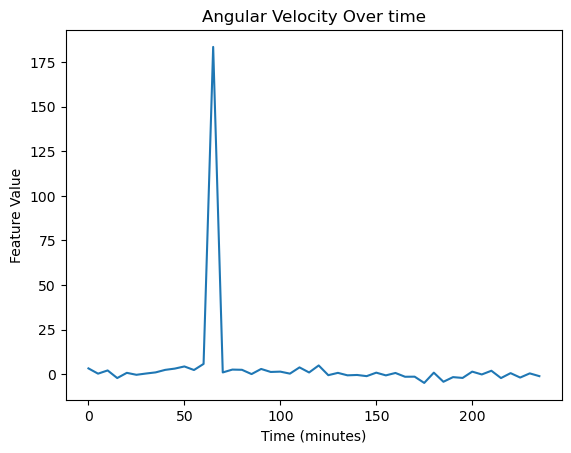

In [36]:
# Dataset for horizon 24 was used to create plots
index = 12
features = ["Semi-Major Axis Length", "Semi-Minor Axis Length", "Ellipse Area", "Axis Ratio", "Ellipse Angle", "Center of Mass X Coordinate", "Center of Mass Y Coordinate", "Non-Zero Pixel Average", "Average", "X Velocity", "Y Velocity", "Velocity Magnitude", "Angular Velocity"]
y = dataset[100][:,index]
x = 5*np.arange(y.size)
plt.plot(x, y)
plt.title(features[index] + " Over time")
plt.xlabel("Time (minutes)")
plt.ylabel("Feature Value")

In [37]:
# maskingThreshold = [114,  65,   50,   50]
# numSTD =           [1,    1,    1,    1]
# input_lengths =    [8,    4,    9,    13]
# horizon_lengths =  [1,    6,    12,   24]

mT = 114
nstd = 1
# input_lengths = [9]
# horizon_lengths = [12]


In [38]:
import pickle
import numpy as np
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
np_path = "D:\\Final Dataset\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\np_array_no_text.npy"
dataset = np.load(np_path)
dataset.shape

(14221, 48, 13)

In [39]:
train_loss[0]

tensor(0.8437, device='cuda:0', grad_fn=<MseLossBackward0>)

In [40]:
globalMeans


array([ 9.66614398e+01,  5.33859227e+01,  1.68279860e+04,  2.08653238e+00,
        2.08202074e+01,  1.94302902e+02,  1.96492029e+02,  9.40706205e+01,
        2.66521630e+02, -3.02702269e-02,  9.65457396e-01,  4.75090776e+00,
       -2.56744372e-02])

In [41]:
globalSTDs

array([2.40607881e+01, 1.96392046e+01, 8.16230222e+03, 1.23708286e+00,
       1.23490053e+02, 5.85331223e+01, 6.10878114e+01, 1.97445022e+01,
       1.76225496e+03, 6.36128224e+00, 6.27675597e+00, 7.63056204e+00,
       4.65778580e+01])

In [81]:
samples = dataset[35]

In [129]:
normalized_sample = (sample - globalMeans) / globalSTDs
# normalized_sample


# maskingThreshold = [50]
# numSTD = [1]
# input_lengths = [9]
# horizon_lengths = [12]



In [130]:
sample_input = normalized_sample[0:9,:]
sample_output = normalized_sample[20]
# sample_output
sample_length = [9]
sample_output_length = [12]

sample_combo = [sample_input, sample_length, sample_output_length]

In [149]:
sample_input = np.array(sample_input, dtype=np.float32)
sample_combo = torch.tensor([sample_input])  # Example: shape [input_dim]
# sample_combo = sample_combo.unsqueeze(0).to(device)  # Shape becomes [1, input_dim]
sample_combo = sample_combo.to(device)  # Shape becomes [1, input_dim]
lengths = torch.tensor([9]).to(device)
output_length = torch.tensor([12]).to(device)

model.to(device)

model.eval()
with torch.no_grad():
    prediction = model(sample_combo, lengths, output_length)

In [159]:
# sample_input

In [151]:
sample_combo.shape

torch.Size([1, 9, 13])

In [152]:
prediction = prediction.cpu().numpy()
prediction = prediction.squeeze()
prediction.shape
# prediction_final = [:,11,:]


(12, 13)

In [153]:
prediction_final = prediction[-1]
prediction_final

array([ 0.61151713, -0.3464145 ,  0.01160984,  0.39079708,  1.0217205 ,
        0.882473  , -0.88995594,  1.460487  ,  0.19734399, -0.0600273 ,
        0.12960452,  0.19402146, -0.10666105], dtype=float32)

In [154]:
prediction_final_denormed = prediction_final * globalSTDs + globalMeans
prediction_final_denormed

array([ 1.11375024e+02,  4.65826174e+01,  1.69227490e+04,  2.56998075e+00,
        1.46992530e+02,  2.45956801e+02,  1.42126569e+02,  1.22907209e+02,
        6.14292056e+02, -4.12120833e-01,  1.77895333e+00,  6.23140057e+00,
       -4.99371774e+00])

In [155]:
# features = ["Semi-Major Axis Length", "Semi-Minor Axis Length", "Ellipse Area", "Axis Ratio", "Ellipse Angle", "Center of Mass X Coordinate", "Center of Mass Y Coordinate", "Non-Zero Pixel Average", "Average", "X Velocity", "Y Velocity", "Velocity Magnitude", "Angular Velocity"]

centerOfMass = [prediction_final_denormed[5], prediction_final_denormed[6]]
semi_major = prediction_final_denormed[0]
semi_minor = prediction_final_denormed[1]
ell_angle = prediction_final_denormed[4]

In [167]:
sample_output_denormed = sample_output * globalSTDs + globalMeans

centerOfMass_og = [sample_output_denormed[5], sample_output_denormed[6]]
semi_major_og = sample_output_denormed[0]
semi_minor_og = sample_output_denormed[1]
ell_angle_og = sample_output_denormed[4]

In [172]:
np_path_with_text = "D:\\Final Dataset\\threshold_" + str(mT) + "_nSTD_" + str(nstd) + "\\np_array_object\\np_array.npy"
event_dataset = np.load(np_path_with_text)

In [180]:
event_id = event_dataset[35][0][0]
file_id = event_dataset[35][0][1]
event_id

'R17061511157841'

In [205]:
catalog_samples = catalog[(catalog.iloc[:, 0] == event_id) & (catalog.iloc[:, 1] == file_id)]
catalog_samples
file_index = int(catalog_samples.iloc[:,2])

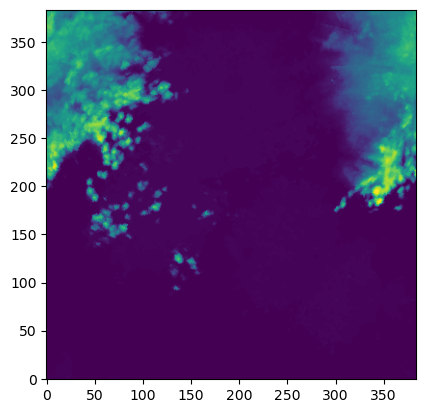

In [208]:
with h5py.File('%s/vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5' % DATA_PATH,'r') as hf:
    vil      = hf['vil'][file_index] 

#     vil = sp.read_data(event_id, 'vil')
# #     fn = sample_event[sample_event.img_type==img_type].squeeze().file_name
# #     fi = sample_event[sample_event.img_type==img_type].squeeze().file_index
#     with h5py.File(data_path + '/' + fn,'r') as hf:
#         data=hf[img_type][fi]

image1 = np.array(vil[:,:,10])
plt.imshow(image1)
plt.gca().invert_yaxis()


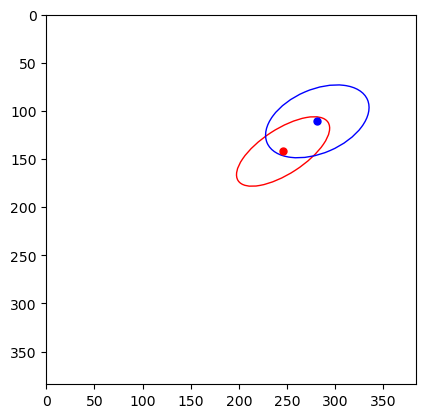

In [168]:
from matplotlib.patches import Ellipse
ax = plt.subplot(111, aspect='equal')
# plt.scatter(image1BinaryWeightedX, image1BinaryWeightedY, s=1, color='mediumseagreen')
# plt.scatter([], [], s=1, color='mediumseagreen')
ax.set_xlim([0, 384])
ax.set_ylim([0, 384])


ell = Ellipse(xy=(centerOfMass[0], centerOfMass[1]),
              width=semi_major, height=semi_minor,
              angle=ell_angle)
ell.set_facecolor('none')
ell.set_edgecolor('red')
ax.add_artist(ell)    
plt.plot(centerOfMass[0], centerOfMass[1], 'or', markersize=5)

plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.axis('off')
# plt.savefig('sample_covariances.png', bbox_inches='tight')
# plt.close()


ell = Ellipse(xy=(centerOfMass_og[0], centerOfMass_og[1]),
              width=semi_major_og, height=semi_minor_og,
              angle=ell_angle_og)
ell.set_facecolor('none')
ell.set_edgecolor('blue')
ax.add_artist(ell)    
plt.plot(centerOfMass_og[0], centerOfMass_og[1], 'ob', markersize=5)

In [227]:
threshold = 100

image1BinaryWeightedX = []
image1BinaryWeightedY = []
image1BinaryX = []
image1BinaryY = []
for (x,y), value in np.ndenumerate(image1):
    if(value > threshold):
        image1BinaryX.append(x)
        image1BinaryY.append(y)
        for z in range(value):
            image1BinaryWeightedX.append(x)
            image1BinaryWeightedY.append(y)            
image1BinaryX = np.array(image1BinaryX)
image1BinaryY = np.array(image1BinaryY)
image1BinaryWeightedX = np.array(image1BinaryWeightedX)
image1BinaryWeightedY = np.array(image1BinaryWeightedY)

In [228]:
ax = plt.subplot(111, aspect='equal')
plt.scatter(image1BinaryWeightedX, image1BinaryWeightedY, s=1, color='mediumseagreen')
ax.set_xlim([0, 384])
ax.set_ylim([0, 384])
ell = Ellipse(xy=(centerOfMass[0], centerOfMass[1]),
              width=semi_major, height=semi_minor,
              angle=ell_angle)
ell.set_facecolor('none')
ell.set_edgecolor('red')
ax.add_artist(ell)    
plt.plot(centerOfMass[0], centerOfMass[1], 'or', markersize=5)

plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.axis('off')

plt.savefig('sample_covariances.png', bbox_inches='tight')
plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


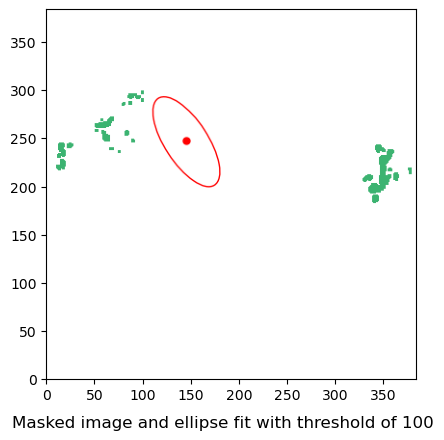

In [229]:
img = plt.imread('sample_covariances.png')
new_img = ndimage.rotate(img, 90)
ax = plt.gca()
ax.set_xlim([0, 384])
ax.set_ylim([0, 384])
# caption = "95% covariance ellipse"
caption = "Masked image and ellipse fit with threshold of " + str(threshold)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
plt.imshow(flipped_img)

In [225]:
# import cv2
